# **Generating Anime Faces with GAN (Generative Adversarial Networks) in pyTorch**

Generative Adversarial Networks (GANs) are a powerful class of neural networks that are used for unsupervised learning. The flow of a GAN model looks like this:

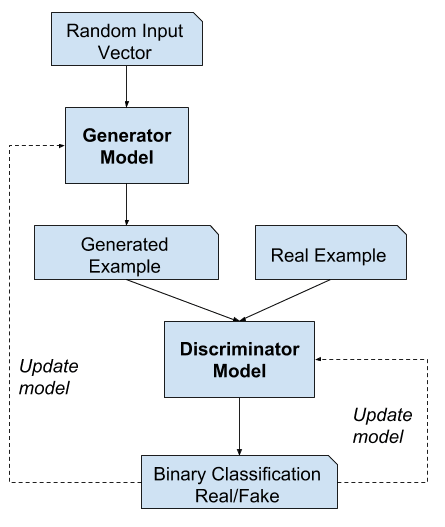

## **Importing the dataset**

Using the opendatasets library to download kaggle datasets

In [ ]:
!pip install opendatasets

The dataset can be found [here](https://www.kaggle.com/datasets/splcher/animefacedataset).

In [ ]:
import opendatasets as od

dataset_url = 'https://www.kaggle.com/splcher/animefacedataset'
od.download(dataset_url)

We load this dataset using the ImageFolder class from torchvision. We will also resize and crop the images to 64x64 px, and normalize the pixel values with a mean & standard deviation of 0.5 for each channel. This will ensure that pixel values are in the range (-1, 1), which is more convenient for training the discriminator. We will also create a data loader to load the data in batches.

In [ ]:
import os
DATA_DIR = './animefacedataset'
print(os.listdir(DATA_DIR))

['images']


In [70]:
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as T

In [71]:
image_size = 64
batch_size = 128
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

In [72]:
train_ds = ImageFolder(DATA_DIR, transform=T.Compose([
    T.Resize(image_size),
    T.CenterCrop(image_size),
    T.ToTensor(),
    T.Normalize(*stats)]))

train = DataLoader(train_ds, batch_size, shuffle=True, num_workers=3, pin_memory=True)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Importing important libraries

In [80]:
import torch
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
%matplotlib inline

We normalize the images

In [81]:
from Normalize_images import show_batch

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


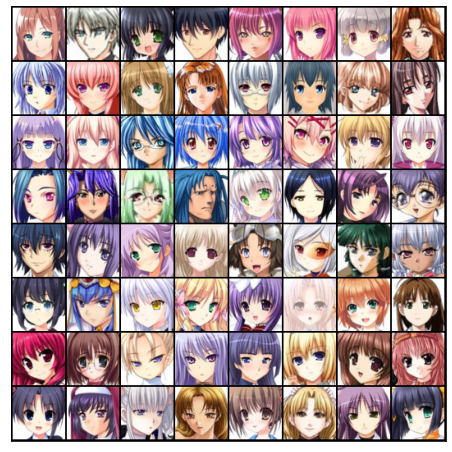

In [87]:
show_batch(train)

In [94]:
from get_device_info import get_default_device
from get_device_info import DeviceDataLoader

In [ ]:
device = get_default_device()
device

device(type='cuda')

In [93]:
train = DeviceDataLoader(train, device)

##**Building the Discriminator Network**
The discriminator takes an image as input, and tries to classify it as "real" or "generated"

In [ ]:
import torch.nn as nn

In [96]:
from get_device_info import to_device
from Discriminator_model import discriminator_model

In [97]:
discriminator = to_device(discriminator_model, device)

## **Building the Generator Network**
The input to the generator is typically a vector or a matrix of random numbers (referred to as a latent tensor) which is used as a seed for generating an image. The generator will convert a latent tensor of shape (128, 1, 1) into an image tensor of shape 3 x 28 x 28.

In [101]:
from Generator_model import generator

The shape of the fake images generated are torch.Size([128, 3, 64, 64])


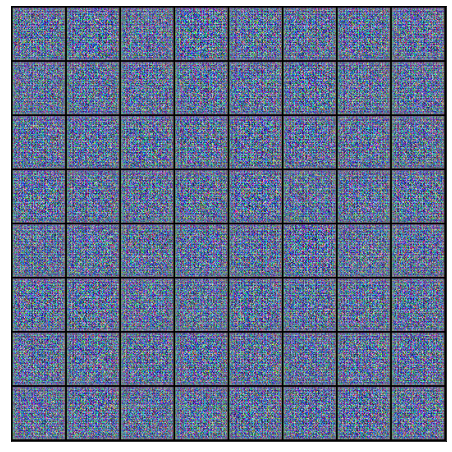

In [100]:
xb = torch.randn(batch_size, sample_size, 1, 1) 
fake_images = generator(xb)
print('The shape of the fake images generated are',fake_images.shape)
show_images(fake_images)

In [102]:
generator = to_device(generator, device)

## **Function for Training the discriminator model**

We use **binary cross entropy** model as it is a binary **(Real/Fake)** classification.

In [ ]:
def train_discriminator(real_images, opt_d):
    # Clear discriminator gradients
    opt_d.zero_grad()

    # Pass real images through discriminator
    real_preds = discriminator(real_images)
    real_targets = torch.ones(real_images.size(0), 1, device=device)
    real_loss = F.binary_cross_entropy(real_preds, real_targets)
    real_score = torch.mean(real_preds).item()
    
    # Generate fake images
    latent = torch.randn(batch_size, sample_size, 1, 1, device=device)
    fake_images = generator(latent)

    # Pass fake images through discriminator
    fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
    fake_preds = discriminator(fake_images)
    fake_loss = F.binary_cross_entropy(fake_preds, fake_targets)
    fake_score = torch.mean(fake_preds).item()

    # Update discriminator weights
    loss = real_loss + fake_loss
    loss.backward()
    opt_d.step()
    return loss.item(), real_score, fake_score

## **Function for Trainig the Generator Model**

We calculate the loss by setting the target labels to 1 i.e. real. We do this because the generator's objective is to "fool" the discriminator. We use the loss to perform gradient descent i.e. change the weights of the generator, so it gets better at generating real-like images to "fool" the discriminator.

In [ ]:
def train_generator(opt_g):
    # Clear generator gradients
    opt_g.zero_grad()
    
    # Generate fake images
    latent = torch.randn(batch_size, sample_size, 1, 1, device=device)
    fake_images = generator(latent)
    
    # Try to fool the discriminator
    preds = discriminator(fake_images)
    targets = torch.ones(batch_size, 1, device=device)
    loss = F.binary_cross_entropy(preds, targets)
    
    # Update generator weights
    loss.backward()
    opt_g.step()
    
    return loss.item()

We create a directory where we can save intermediate outputs from the generator to visually inspect the progress of the model. 

In [104]:
from save_sample import save_samples

In [ ]:
fixed_latent = torch.randn(64, sample_size, 1, 1, device=device).cuda()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saving generated-images-0000.png


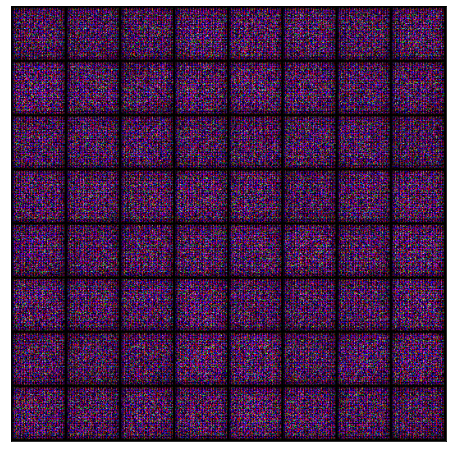

In [ ]:
save_samples(0, fixed_latent)

## **Fitting the model**

Wdefine a fit function to train the discriminator and generator in tandem for each batch of training data. We'll use the Adam optimizer

In [ ]:
from tqdm.notebook import tqdm
import torch.nn.functional as F

In [ ]:
def fit(epochs, lr, start_idx=1):
    torch.cuda.empty_cache()
    
    # Losses & scores
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []
    
    # Create optimizers
    opt_d = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
    opt_g = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
    
    for epoch in range(epochs):
        for real_images, _ in tqdm(train):
            # Train discriminator
            loss_d, real_score, fake_score = train_discriminator(real_images, opt_d)
            # Train generator
            loss_g = train_generator(opt_g)
            
        # Record losses & scores
        losses_g.append(loss_g)
        losses_d.append(loss_d)
        real_scores.append(real_score)
        fake_scores.append(fake_score)
        
        # Log losses & scores (last batch)
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch+1, epochs, loss_g, loss_d, real_score, fake_score))
    
        # Save generated images
        save_samples(epoch+start_idx, fixed_latent, show=False)
    
    return losses_g, losses_d, real_scores, fake_scores

In [ ]:
lr = 0.0002
epochs = 10
history = fit(epochs, lr)

  0%|          | 0/497 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch [1/10], loss_g: 11.8510, loss_d: 1.5038, real_score: 0.9428, fake_score: 0.7081
Saving generated-images-0001.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [2/10], loss_g: 9.3662, loss_d: 0.7793, real_score: 0.9303, fake_score: 0.4564
Saving generated-images-0002.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [3/10], loss_g: 10.5138, loss_d: 0.6482, real_score: 0.9404, fake_score: 0.3952
Saving generated-images-0003.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [4/10], loss_g: 5.8154, loss_d: 0.2133, real_score: 0.9174, fake_score: 0.1016
Saving generated-images-0004.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [5/10], loss_g: 3.7553, loss_d: 0.0692, real_score: 0.9698, fake_score: 0.0343
Saving generated-images-0005.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [6/10], loss_g: 12.4443, loss_d: 0.6784, real_score: 0.9775, fake_score: 0.4108
Saving generated-images-0006.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [7/10], loss_g: 16.4669, loss_d: 0.1099, real_score: 0.9230, fake_score: 0.0000
Saving generated-images-0007.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [8/10], loss_g: 8.8731, loss_d: 0.2142, real_score: 0.8561, fake_score: 0.0004
Saving generated-images-0008.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [9/10], loss_g: 6.6742, loss_d: 0.0940, real_score: 0.9595, fake_score: 0.0479
Saving generated-images-0009.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [10/10], loss_g: 8.5884, loss_d: 0.1077, real_score: 0.9642, fake_score: 0.0453
Saving generated-images-0010.png


In [ ]:
losses_g, losses_d, real_scores, fake_scores = history

In [ ]:
# Save the model checkpoints 
torch.save(generator.state_dict(), 'G.pth')
torch.save(discriminator.state_dict(), 'D.pth')

## Importing as a video

In [ ]:
import cv2
import os

vid_fname = 'gans_training.avi'

files = [os.path.join(sample_dir, f) for f in os.listdir(sample_dir) if 'generated' in f]
files.sort()

out = cv2.VideoWriter(vid_fname,cv2.VideoWriter_fourcc(*'MP4V'), 1, (530,530))
[out.write(cv2.imread(fname)) for fname in files]
out.release()

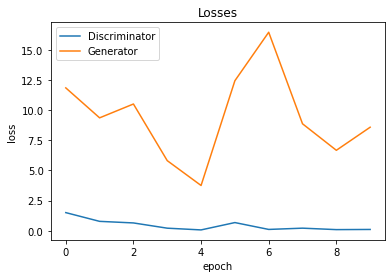

In [ ]:
plt.plot(losses_d, '-')
plt.plot(losses_g, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');

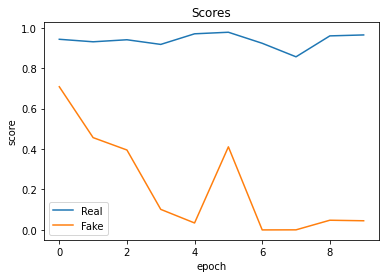

In [ ]:
plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real', 'Fake'])
plt.title('Scores');



---

